<a id="top5"></a>
# Support Vector Machine - SVM

In this notebook I will implement a Support Vector Machine model with hyperparametes tuning and analysis:

- [Data preparation](#part6a)
- [Support Vector Machine model with tuning](#part6b)
- [Confusion matrix](#part6c)

### <a id='part6a'>Data preparation</a>

Let's import the dataset previously exported and extract `X` feature matrix and `y` numerical target:

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")

# Import the dataset and verify that the upload is successful
df = pd.read_csv('emotions_data_transformed.csv')

# Convert target to numerical values
df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
df['gender'].replace({'female':0,'male':1}, inplace=True)

# Create feature matrix (X) and numerical target (y)
X = df.drop(columns=['path','filename','dataset','duration','age','emotion'])
y = df.emotion.values

Let's split the data, into training and test set. 

In [2]:
from sklearn.model_selection import train_test_split

# Create train, validation and test set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.9, shuffle=True, stratify=y, random_state=0)

# Check size
print('Shape of x_tr: ', X_tr.shape)
print('Shape of y_tr: ', y_tr.shape)
print('Shape of x_te: ', X_te.shape)
print('Shape of y_te: ', y_te.shape)

Shape of x_tr:  (8361, 90)
Shape of y_tr:  (8361,)
Shape of x_te:  (930, 90)
Shape of y_te:  (930,)


Let's rescale the data:

In [3]:
# Scale the data
from sklearn.preprocessing import StandardScaler

# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

### <a id='part6b'>SVM model with tuning</a>

Now to the Support Vector Machine model fitting and tuning. I chose to implement a **model with RBF kernel**, and find the optimal hyperparameters `Gamma` and `C`. I use again cross validation grid search with KFold strategy and a `balanced` class weigth due to the differences of samples in the classes.

In [4]:
%%time

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Create SVM with RBF kernel
rbf_svc = SVC(class_weight="balanced", random_state=0)

# Create k-fold object for cross-validation with shuffle
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Create a list of parameter
param_grid = {
     "kernel": ["rbf"],
     "gamma": np.logspace(-4,4,num=9),   # Gamma
     "C": np.logspace(-4,4,num=9)        # Regularization strenght parameter C
    }

# Instantiate the grid search model
grid_cv = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv = kfold, n_jobs = -1, return_train_score=1)

# Fit estimator
grid_cv.fit(X_tr_rescaled,y_tr)

CPU times: user 3.36 s, sys: 333 ms, total: 3.7 s
Wall time: 39min 38s


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'kernel': ['rbf']},
             return_train_score=1)

In [5]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print the columns with score and hyperparameters
cols = [
    'mean_test_score',
    'param_C',
    'param_gamma',
]

# Display fist 10 columns with higher mean validation score
cv_results[cols].sort_values(by="mean_test_score", ascending=False).head()

,mean_test_score,param_C,param_gamma
56,0.945222,100.0,0.01
74,0.945222,10000.0,0.01
65,0.945222,1000.0,0.01
47,0.944982,10.0,0.01
64,0.919387,1000.0,0.001


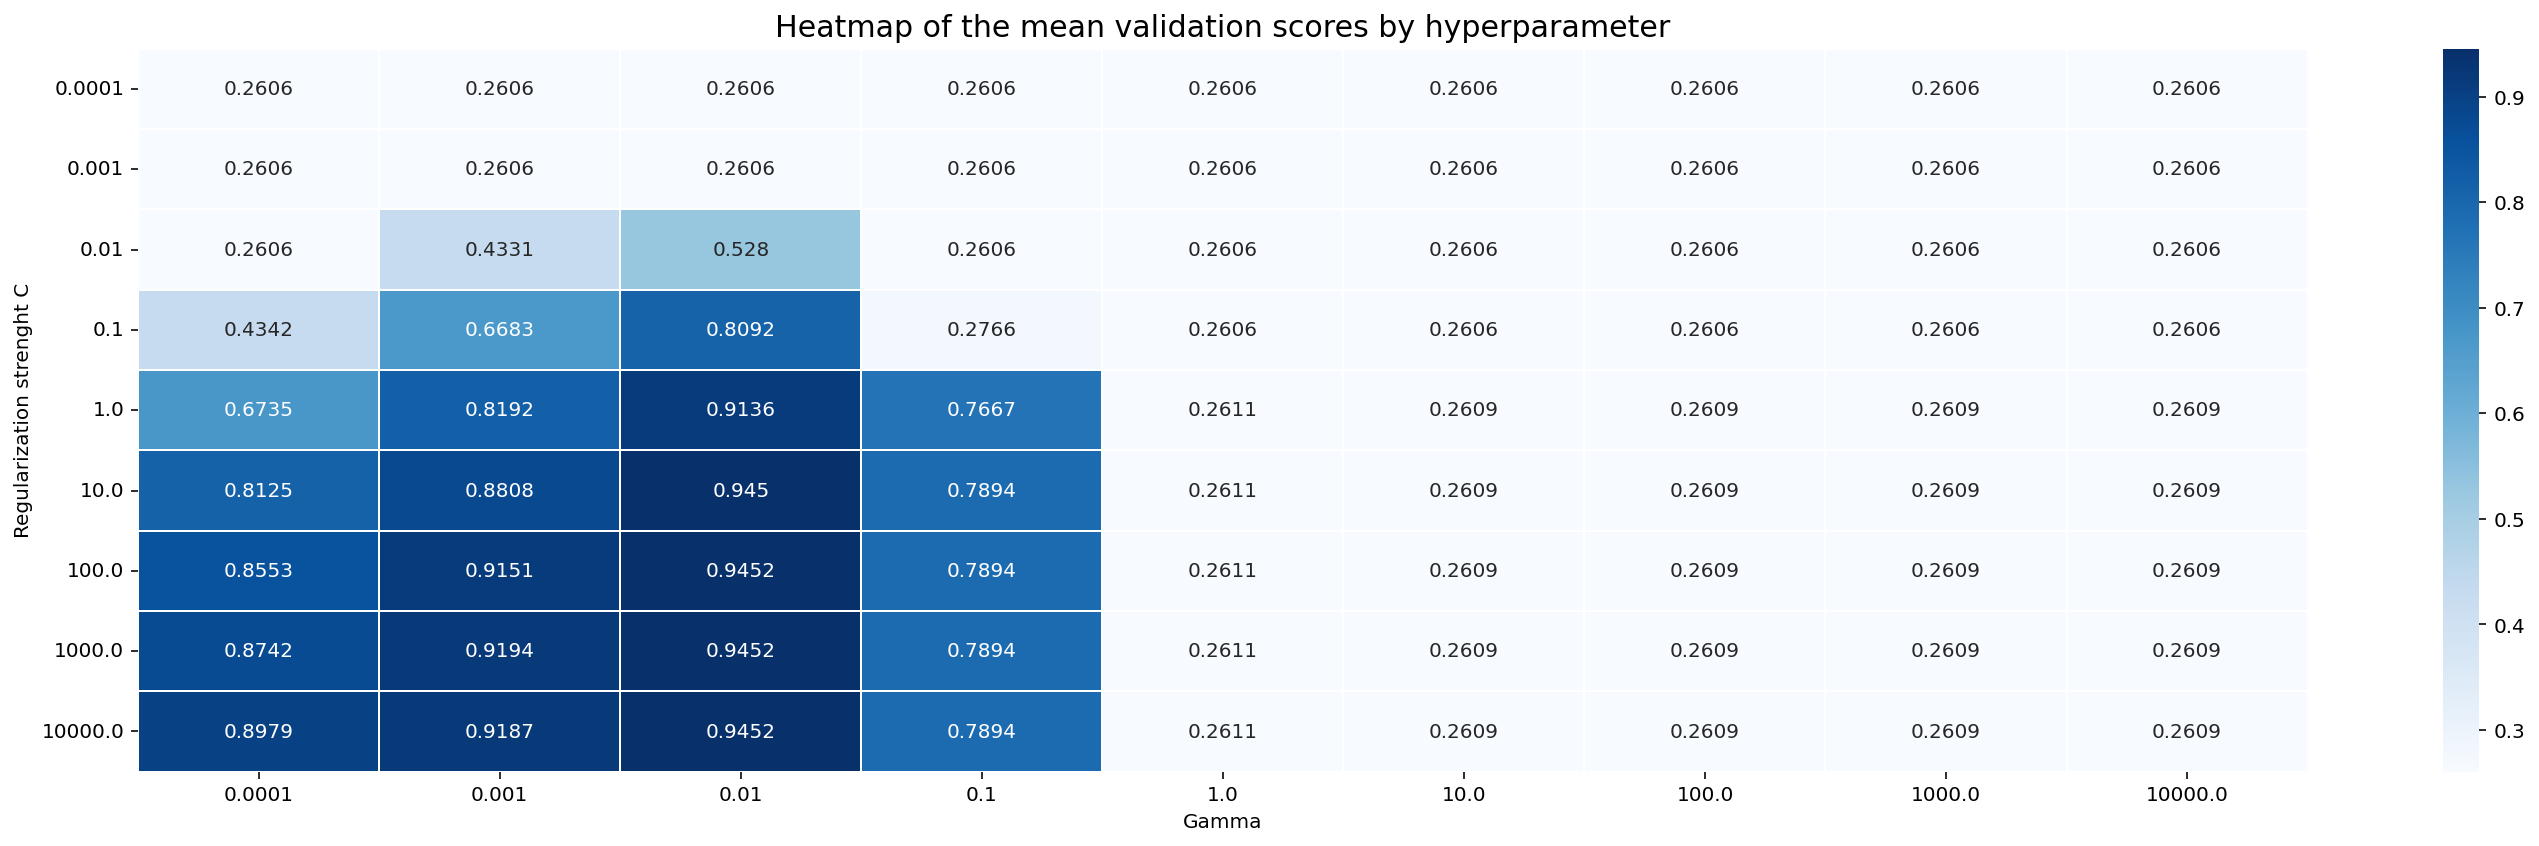

In [6]:
# Create DataFrame to host heatmap data
df_heatmap = cv_results[cols].pivot(index='param_C', columns='param_gamma', values='mean_test_score') 

# Plotting the results
plt.figure(figsize=(20,6))
sns.heatmap(df_heatmap, annot=True, linewidths=1, fmt=".4g", cmap="Blues")
plt.title('Heatmap of the mean validation scores by hyperparameter', size=15)
plt.xlabel('Gamma')
plt.ylabel('Regularization strenght C')
plt.tight_layout()
plt.show()

We can thus see that in the Support Vector Machine model with RBF kernel the best hyperparameters are the regularization strenght C of `100` and the gamma value of `0.01`. It appears that with values of gamma > 1 the accuracy of the model decreases sharply, as well as with a value of C less than < 0.1.

Let's see the training curves as well:

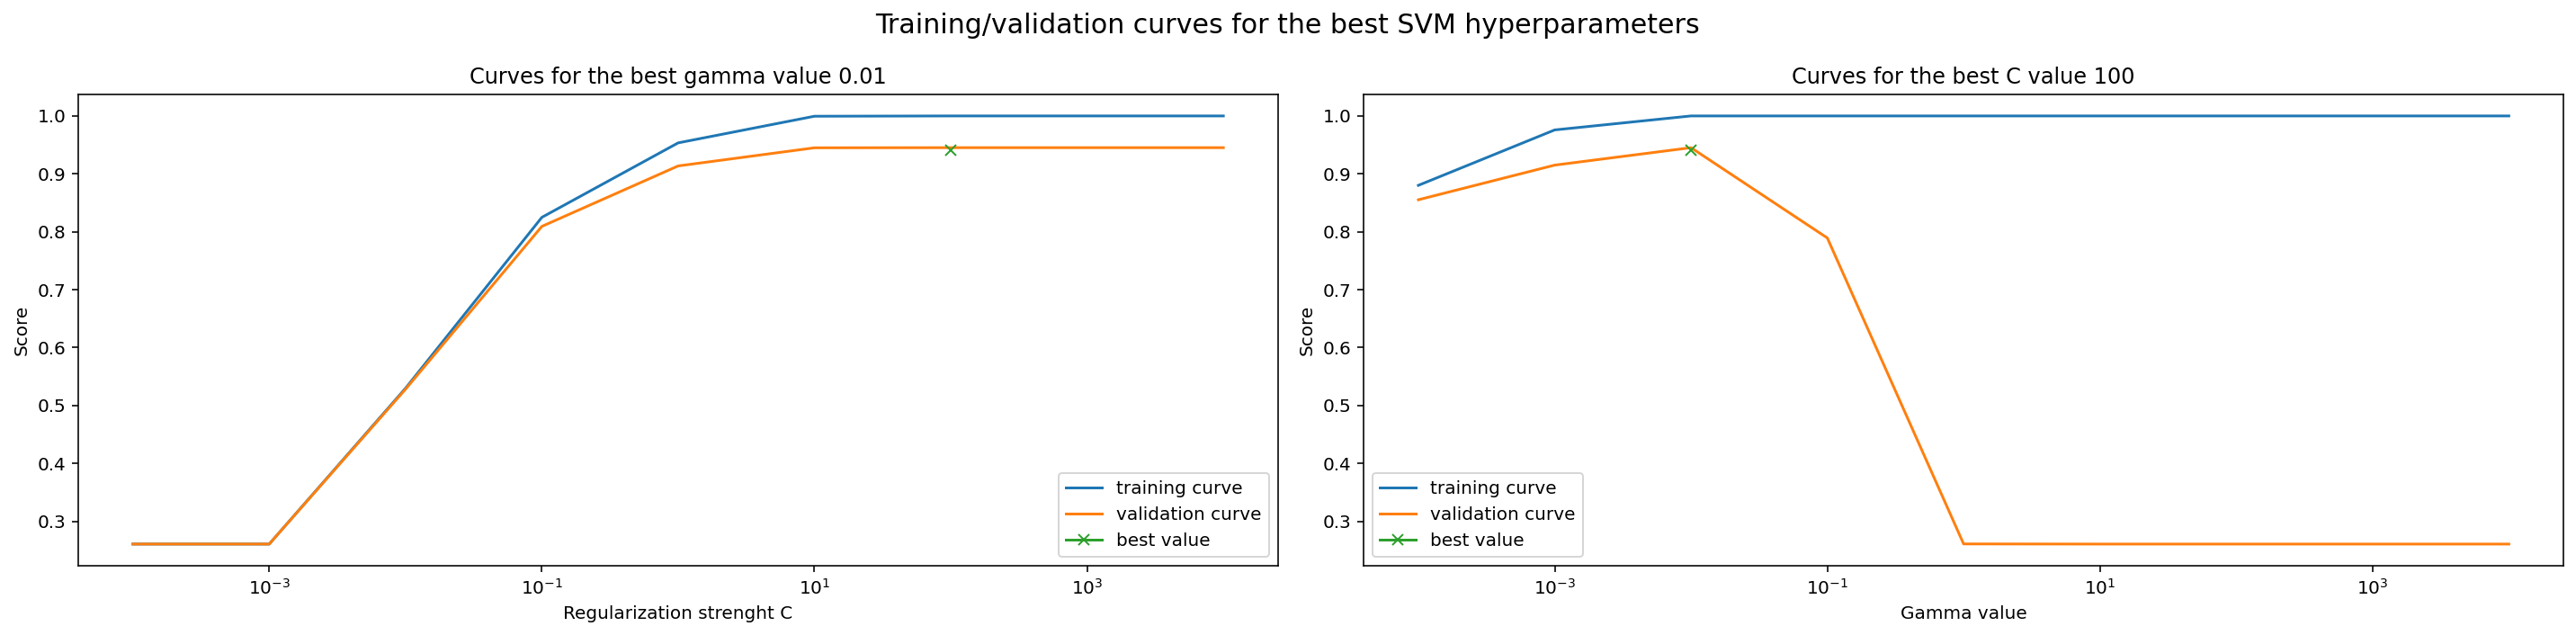

In [7]:
# Creates a figure with multiple subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=False)

# Plot the training/validation curves
df_cv = cv_results[(cv_results["param_gamma"] == 0.01)]
axs[0].semilogx(df_cv["param_C"], df_cv["mean_train_score"], label="training curve")
axs[0].semilogx(df_cv["param_C"], df_cv["mean_test_score"], label="validation curve")
axs[0].plot(100, 0.9414, marker="x", label = "best value")
axs[0].set_xlabel('Regularization strenght C')
axs[0].set_ylabel('Score')
axs[0].set_title('Curves for the best gamma value 0.01')
axs[0].legend(loc="lower right")

df_cv = cv_results[(cv_results["param_C"] == 100)]
axs[1].semilogx(df_cv["param_gamma"], df_cv["mean_train_score"], label="training curve")
axs[1].semilogx(df_cv["param_gamma"], df_cv["mean_test_score"], label="validation curve")
axs[1].plot(0.01, 0.9414, marker="x", label = "best value")
axs[1].set_xlabel('Gamma value')
axs[1].set_ylabel('Score')
axs[1].set_title('Curves for the best C value 100')
axs[1].legend(loc="lower left")


plt.suptitle('Training/validation curves for the best SVM hyperparameters', size=15)
plt.tight_layout()
plt.show()

As shown in the first graph with the training curve, we can see that the classifier is improving for high values of C, however after a while (10~100) both curves becomes flat. We also see the model overfits when the gamma value exced 0.1 as the training curve remains very high, while the validation curve sharply loses accuracy.

Let's compute now the scores for the test sets:

In [8]:
best_svm = SVC(kernel='rbf', C=100, gamma=0.01, probability=True)

best_svm.fit(X_tr_rescaled,y_tr)

print('Test accuracy of the SVC classifier with RBF kernel: {:.3f}'.format(best_svm.score(X_te_rescaled, y_te)))

Test accuracy of the SVC classifier with RBF kernel: 0.961


The RBF kernel even performed slightly better in the test score than with the validation set.

### <a id='part6c'>Confusion matrix</a>

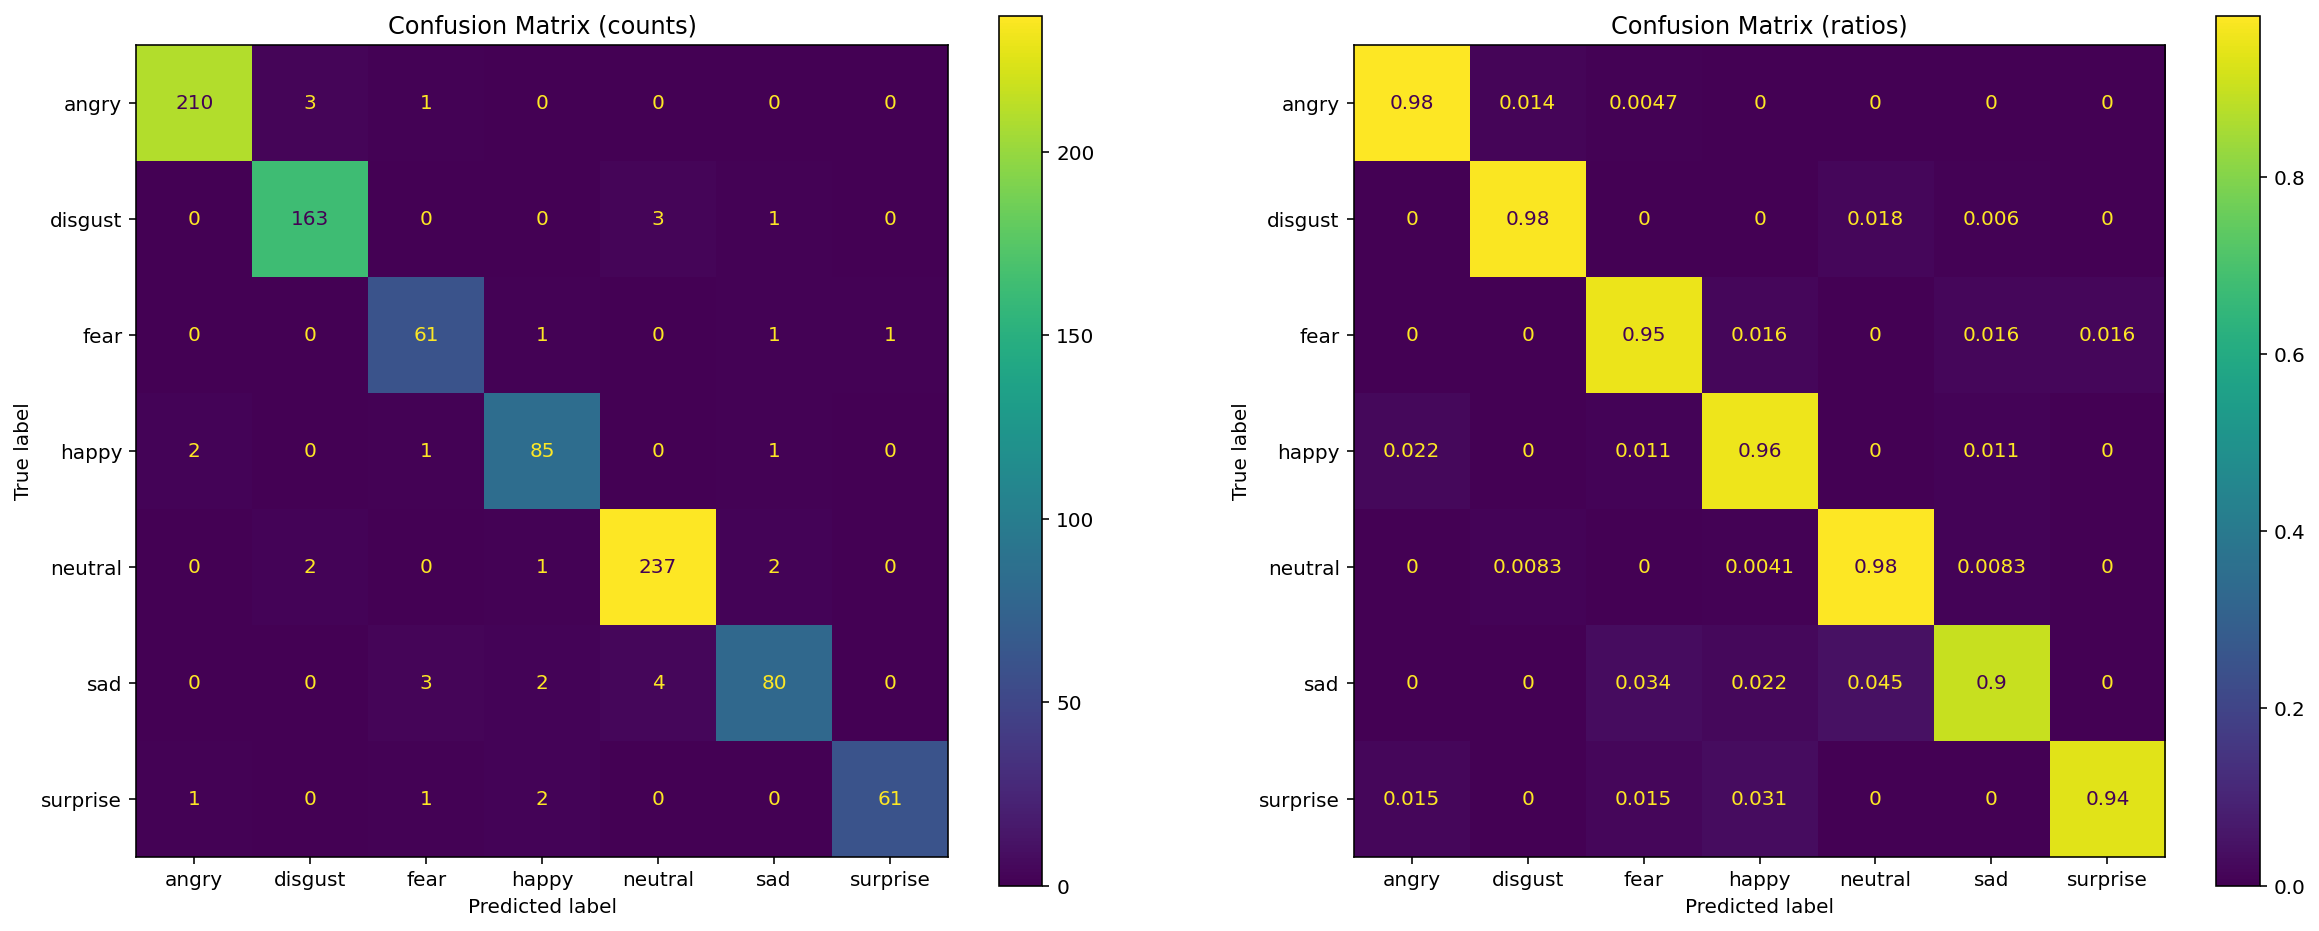

In [9]:
# Predicting the categories
y_probabilities = best_svm.predict_proba(X_te_rescaled)

predicted = []

for i in y_probabilities:
    predicted.append(np.argmax(i))
    
# Define confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)

    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, predicted)

- A lot of categories have very good scores
- The worst scores belong to the `happy` and `sad` categories

<br>[Back to top](#top6)